In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

import warnings
import re

Savee dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [2]:
Savee = "../input/speech-emotion-recognition-en/Savee"

savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,happy,../input/speech-emotion-recognition-en/Savee/J...
1,fear,../input/speech-emotion-recognition-en/Savee/K...
2,happy,../input/speech-emotion-recognition-en/Savee/D...
3,disgust,../input/speech-emotion-recognition-en/Savee/D...
4,angry,../input/speech-emotion-recognition-en/Savee/K...


<AxesSubplot:xlabel='Emotion', ylabel='Count'>

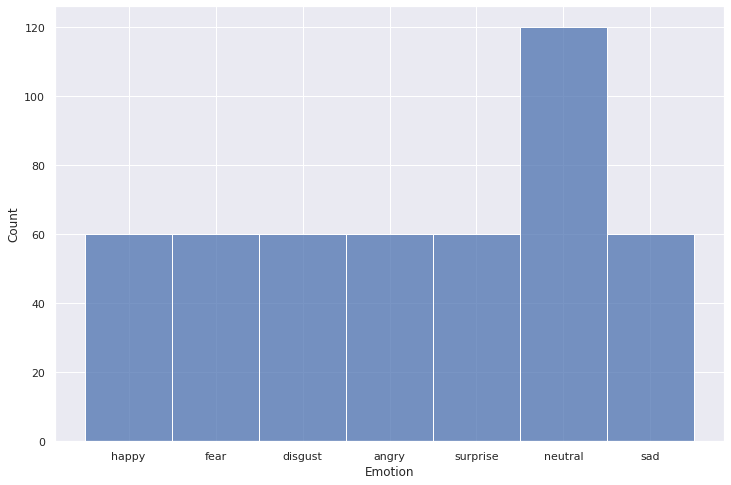

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(Savee_df['Emotion'])

In [4]:
audio_arrays = []

for i in Savee_df['Path']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
Savee_df['Arrays'] = audio_arrays
Savee_df

,Emotion,Path,Arrays
0,happy,../input/speech-emotion-recognition-en/Savee/J...,"[0.014984131, 0.014984131, 0.014984131, 0.0149..."
1,fear,../input/speech-emotion-recognition-en/Savee/K...,"[0.0045776367, 0.004547119, 0.004547119, 0.004..."
2,happy,../input/speech-emotion-recognition-en/Savee/D...,"[0.03955078, 0.03955078, 0.0395813, 0.03955078..."
3,disgust,../input/speech-emotion-recognition-en/Savee/D...,"[0.039123535, 0.0390625, 0.039031982, 0.039062..."
4,angry,../input/speech-emotion-recognition-en/Savee/K...,"[0.0016784668, 0.0016479492, 0.0016479492, 0.0..."
...,...,...,...
475,surprise,../input/speech-emotion-recognition-en/Savee/J...,"[0.013946533, 0.013916016, 0.013885498, 0.0138..."
476,neutral,../input/speech-emotion-recognition-en/Savee/D...,"[0.05206299, 0.052093506, 0.052093506, 0.05206..."
477,neutral,../input/speech-emotion-recognition-en/Savee/J...,"[0.03955078, 0.03955078, 0.0395813, 0.03964233..."
478,angry,../input/speech-emotion-recognition-en/Savee/K...,"[0.0015258789, 0.0014953613, 0.0014953613, 0.0..."


In [5]:
emotion = ['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad']

In [6]:
x = []
y = []
i = 1
for sample in range(len(Savee_df)):
    
    data , sr = librosa.load(Savee_df['Path'].iloc[sample])
    
    #MFCC
    feature = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    
    x.append(feature)

    trueLabel = ( np.array(emotion) == Savee_df['Emotion'].iloc[sample] ).astype(int)
    
    if(i % 50 == 0):
        print(f"Sample {i} done")
        
    i = i+1
    
    y.append(trueLabel)

/opt/conda/lib/python3.7/site-packages/librosa/feature/spectral.py:2041: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Sample 50 done
Sample 100 done
Sample 150 done
Sample 200 done
Sample 250 done
Sample 300 done
Sample 350 done
Sample 400 done
Sample 450 done


In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

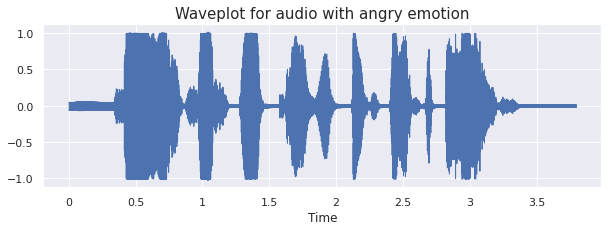

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


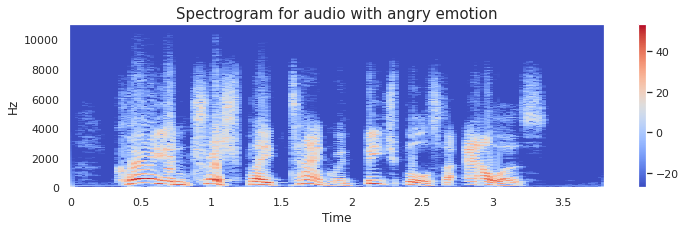

In [8]:
from IPython.display import Audio

emotion='angry'
path = np.array(Savee_df.Path[Savee_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
data_x = np.array(x)
data_y = np.array(y)

print(data_x.shape)
print(data_y.shape)

(480, 20)
(480, 7)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

In [12]:
x_train, x_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.05)

In [13]:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(364, 20)
(20, 20)
(364, 7)
(20, 7)


In [14]:
x_train = np.expand_dims(x_train, axis=2)
x_validation = np.expand_dims(x_validation, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [15]:
import time
import tensorflow as tf
from keras import regularizers

def audio_recognition(n_classes,input_):
    weight_initializer = tf.keras.initializers.GlorotUniform()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,
                                input_shape=(input_, 1),
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.LSTM(units=256,
                                kernel_initializer=weight_initializer,
                                dropout=0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dense(units=256,activation='relu',kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=n_classes,activation='sigmoid',kernel_initializer=weight_initializer,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
    return model

In [16]:
model = audio_recognition(input_ = 20,n_classes=7 )

2022-03-10 15:03:45.256446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 15:03:45.390543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 15:03:45.391677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 15:03:45.393311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [20]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy', optimizer=adam , metrics=['binary_accuracy'])


history = model.fit(x_train, y_train, epochs=50,validation_data = (x_validation, y_validation),callbacks= [early_stopping, learning_rate_reduction],batch_size=8)

model.evaluate(X_test, y_test)

Epoch 1/50
46/46 [==============================] - 13s 69ms/step - loss: 0.8856 - binary_accuracy: 0.5655 - val_loss: 0.9227 - val_binary_accuracy: 0.4214
Epoch 2/50
46/46 [==============================] - 1s 22ms/step - loss: 0.8643 - binary_accuracy: 0.5801 - val_loss: 0.9088 - val_binary_accuracy: 0.5643
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 0.8427 - binary_accuracy: 0.6122 - val_loss: 0.8576 - val_binary_accuracy: 0.5429
Epoch 4/50
46/46 [==============================] - 1s 22ms/step - loss: 0.8288 - binary_accuracy: 0.6562 - val_loss: 0.8460 - val_binary_accuracy: 0.6500
Epoch 5/50
46/46 [==============================] - 1s 22ms/step - loss: 0.8192 - binary_accuracy: 0.6774 - val_loss: 0.7666 - val_binary_accuracy: 0.7214
Epoch 6/50
46/46 [==============================] - 1s 22ms/step - loss: 0.8012 - binary_accuracy: 0.7241 - val_loss: 0.8132 - val_binary_accuracy: 0.6357
Epoch 7/50
46/46 [==============================] - 1s 22ms/step - lo

[0.6617624163627625, 0.8139881491661072]

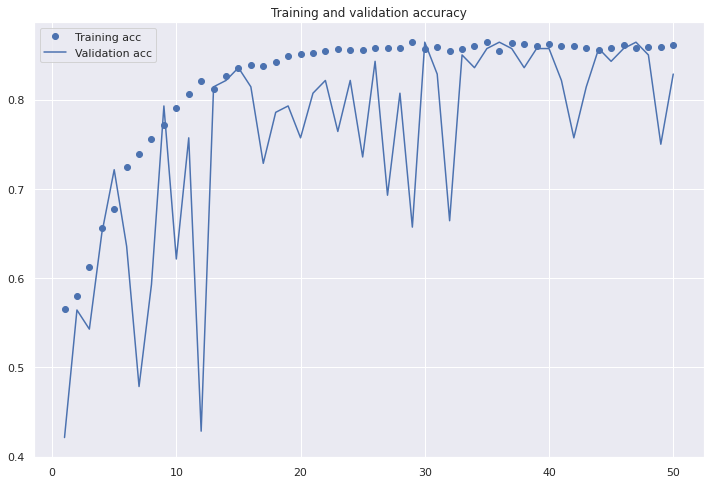

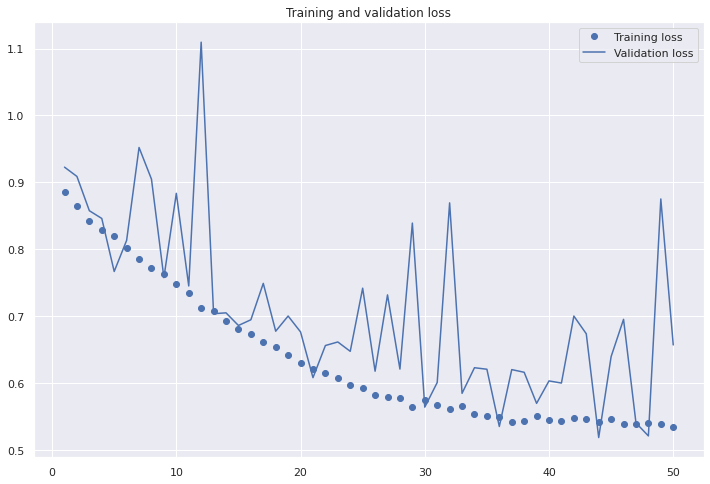

In [22]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()